In [5]:
import os
import numpy as np
import pandas as pd
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score, silhouette_score, pairwise_distances
from scipy.spatial import distance
import dimod as dmd
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler, EmbeddingComposite

In [6]:
np.random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [7]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "data"))
antique_doc_embeddings_path = os.path.join(data_dir, "antique_doc_embeddings.csv")

train_df = pd.read_csv(antique_doc_embeddings_path)
train_df['doc_embeddings'] = [np.fromstring(vec[1:-1], dtype=float, sep=',') for vec in train_df['doc_embeddings']]
doc_embeddings = np.stack(train_df["doc_embeddings"].values)

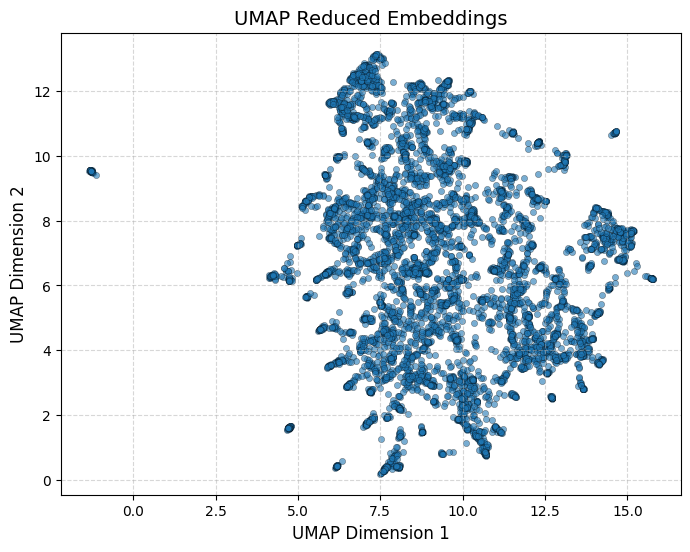

In [8]:
class UMAPReducer:
    def __init__(self, n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean'):
        self.reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)

    def fit_transform(self, embeddings):
        return self.reducer.fit_transform(embeddings)

    def plot_embeddings(self, reduced_embeddings, save_path=None):
        plt.figure(figsize=(8, 6))

        plt.scatter(
            reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
            s=20, alpha=0.6, edgecolors="k", linewidth=0.3, label="Documents"
        )

        plt.title('UMAP Reduced Embeddings', fontsize=14)
        plt.xlabel("UMAP Dimension 1", fontsize=12)
        plt.ylabel("UMAP Dimension 2", fontsize=12)

        plt.grid(True, linestyle="--", alpha=0.5)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"Saved UMAP plot at: {save_path}")

        plt.show()


umap_reducer = UMAPReducer()
doc_embeddings_reduced = umap_reducer.fit_transform(doc_embeddings)

shuffle_indices = np.random.permutation(len(doc_embeddings_reduced)) # KEY STEP
doc_embeddings_reduced = doc_embeddings_reduced[shuffle_indices]

np.save(os.path.join(data_dir, "doc_embeddings_reduced.npy"), doc_embeddings_reduced)

_ = umap_reducer.plot_embeddings(doc_embeddings_reduced)

In [9]:
class ClassicalClustering:
    def __init__(self, k_range=[10, 25, 50, 75, 100], metric='euclidean'):
        self.k_range = k_range
        self.metric = metric
    
    def find_optimal_k(self, embeddings):
        best_score, best_k, best_labels, best_medoid_indices = float('inf'), None, None, None
        for k in self.k_range:
            model = KMedoids(n_clusters=k, metric=self.metric, random_state=42)
            labels = model.fit_predict(embeddings)
            score = davies_bouldin_score(embeddings, labels)
            if score < best_score:
                best_score, best_k, best_labels, best_medoid_indices = score, k, labels, model.medoid_indices_
        return best_labels, best_medoid_indices
    
    def extract_medoids(self, embeddings, medoid_indices):
        return embeddings[medoid_indices]

In [10]:
clustering = ClassicalClustering()
kmedoid_labels, medoid_indices = clustering.find_optimal_k(doc_embeddings_reduced)
medoid_embeddings = clustering.extract_medoids(doc_embeddings_reduced, medoid_indices)
np.save(os.path.join(data_dir, "medoid_embeddings.npy"), medoid_embeddings)
np.save(os.path.join(data_dir, "medoid_indices.npy"), medoid_indices)

In [11]:
print("Medoid Indices Shape:", medoid_indices.shape)
print("First 10 Medoid Indices:", medoid_indices[:10])

print("Medoid Embeddings Shape:", medoid_embeddings.shape)
print("First 5 Medoid Embeddings:\n", medoid_embeddings[:5])

Medoid Indices Shape: (100,)
First 10 Medoid Indices: [ 669  243 5873 4027 3309 5318 4045 6085 4239 1214]
Medoid Embeddings Shape: (100, 2)
First 5 Medoid Embeddings:
 [[8.714324  6.621335 ]
 [9.08119   7.0269327]
 [7.10618   8.186654 ]
 [8.272229  6.458997 ]
 [8.885292  6.3844004]]


In [12]:
len(medoid_indices)

100

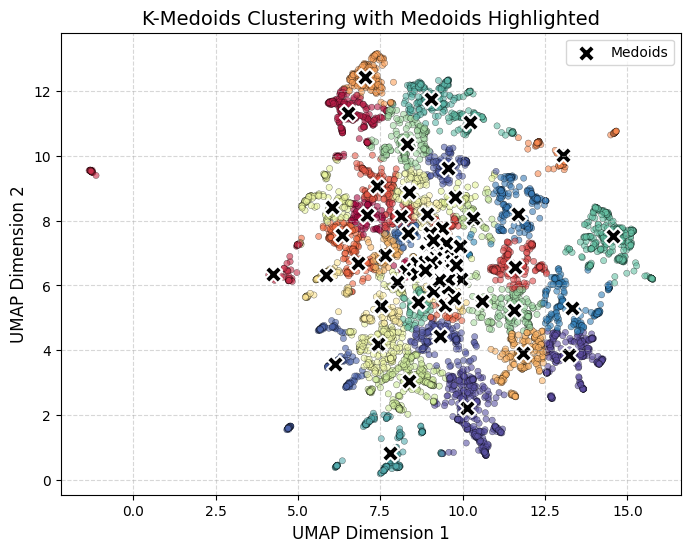

In [13]:
plt.figure(figsize=(8, 6))

plt.scatter(
    doc_embeddings_reduced[:, 0], doc_embeddings_reduced[:, 1], 
    c=kmedoid_labels, cmap="Spectral", 
    s=20, alpha=0.6, edgecolors="k", linewidth=0.3,
)

plt.scatter(
    medoid_embeddings[:, 0], medoid_embeddings[:, 1], 
    c='black', marker='X', s=150, label="Medoids", edgecolors="white", linewidth=1.5
)

plt.title("K-Medoids Clustering with Medoids Highlighted", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)

plt.legend(loc="upper right", fontsize=10, frameon=True)

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [14]:
np.random.shuffle(doc_embeddings_reduced)

In [ ]:
class QuboSolver:
    # AP: All methods to build the Q-matrix should be here, QuboSolver should not be calling stuff from Clusterrun

    def __init__(self, n_clusters, num_reads=100):
        self.n_clusters = n_clusters # AP: this would be equal to k in your case
        self.num_reads = num_reads
        self.bqm = None

    # AP: Consider abstracting this away, as this can be reused for other methods too - just needs a Qubo matrix.
    def run_QuboSolver(self, data, bqm_method='kmedoids'):
        
        # AP: build the qubo matrix. There are many ways to handle this, 
        # I suggest that you abstract the whole QUBO matrix building elsewhere, and keep this class just for the solver and utilities around it.
        # Take a look at the Instance Selection class for an example. Alternatively, you keep adding different methods here.
        if bqm_method == 'kmedoids':
            qubo_dict = self.BQM_kmedoids(data)
        # elif bqm_method = 'anothermethod1':
        #     pass    
        # elif bqm_method = 'anothermethod2':
        #     pass    

        sampler = SimulatedAnnealingSampler()
        bqm = dmd.BinaryQuadraticModel.from_qubo(qubo_dict)
        response = sampler.sample(bqm, num_reads=self.num_reads)
        
        print("Raw QUBO Response:", response.first.sample)  # Debugging output

        best_sample = response.first.sample
        return self._decode_clusters(best_sample)

    def BQM_kmedoids(self, data): #AP: This is just really for the kmedoids approach, should be named properly
        """Build QUBO matrix with penalty terms (α, β, γ)."""
        N = len(data)
        alpha = 1 / self.n_clusters
        beta = 1 / N
        gamma = 2

        W = self._compute_corrloss(data) # equal to delta in their case

        Q = gamma - alpha * W / 2

        for i in range(N):
            Q[i, i] += beta * np.sum(W[i]) - 2 * gamma * self.n_clusters

        Q = self.to_upper_triangular(Q)
        dictQ = self.matrix_to_dict(Q)

        # Print debugging info
        print(f"Penalty terms - α: {alpha}, β: {beta}, γ: {gamma}")
        print(f"QUBO Matrix Min: {np.min(Q)}, Max: {np.max(Q)}, Mean: {np.mean(Q)}")
        print(f"QUBO Matrix Sample:\n{Q[:5, :5]}")

        # AP: plotting it could be a nice debugging tool too

        return dictQ
    
    def _compute_corrloss(self, data):
        """Compute normalized correntropy loss for QUBO matrix."""
        D = distance.squareform(distance.pdist(data, metric='euclidean'))
        
        W = 1 - np.exp(-D / (np.max(D) + 1e-5))
        return W

    def _decode_clusters(self, sample):
        """Extract cluster indices from QUBO solution."""
        cluster_indices = [i for i, v in sample.items() if v == 1]
        print("Decoded Medoid Indices:", cluster_indices)  # Debugging output

        if len(cluster_indices) == 0:
            print("Warning: No valid medoid indices selected by QUBO Solver.")
        return np.array(cluster_indices, dtype=int)
    
    @staticmethod
    def to_upper_triangular(M):
        """Convert the matrix to an upper triangular form required for QUBO."""
        diag = np.diag(M)
        diagM = np.diag(diag)

        M1 = M - diagM
        M2 = np.triu(M1)
        M2 *= 2

        return M2 + diagM

    @staticmethod
    def matrix_to_dict(M):
        """Convert a QUBO matrix to a dictionary format required by D-Wave solvers."""
        q = {}
        for i in range(len(M)):
            for j in range(i, len(M)):
                if M[i, j] != 0:
                    q[(i, j)] = M[i, j]
        return q
 
# AP: This is where you do the loop, it stays on top of the hierarchy, calling everything else, for a given dataset.
# In particular, it runs with kmedoids right now. As such, to comptue QUBO stuff it should be calling only methods from the k-medoids solver class 
# When we add another method, it should be calling it only. You can put in general clustering related tasks like decoding and compute_clusters.

class QuantumClustering:
    def __init__(self, k_range, data):
        self.k_range = k_range
        self.data = data

    def solve_qubo(self):
        """Select medoids using QUBO and compute silhouette score."""
        best_dbi = float("inf")
        best_k = None
        best_refined_medoid_indices = None

        silhouettes_quantum = {}

        print(f"Starting QUBO solving. Current best DBI={best_dbi}")

        for k in self.k_range: # AP: k is really the number of clusters. This means, the number of 1's in the binary vector of the qubo formulation x^T Q x
            # AP: We iterate over number of clusters that we want to pick after the initial sampling with classical kmedoids
            print(f"Solving QUBO for k={k}")

            solver = QuboSolver(n_clusters = k)
            refined_medoid_indices = solver.run_QuboSolver(self.data, bqm_method='kmedoids')

            print(f"Refined medoid indices from QUBO Solver: {refined_medoid_indices}")

            if refined_medoid_indices is None or len(refined_medoid_indices) == 0:
                print(f"Warning: No valid medoids found for k={k}. Skipping DBI computation.")
                continue

            final_cluster_labels = compute_clusters(doc_embeddings_reduced, refined_medoid_indices)
            
            silhouettes_quantum[k] = silhouette_score(doc_embeddings_reduced, final_cluster_labels)

            dbi = davies_bouldin_score(doc_embeddings_reduced, final_cluster_labels)

            if dbi < best_dbi:
                best_dbi = dbi
                best_k = k
                best_refined_medoid_indices = refined_medoid_indices

        print(f"Selected k={best_k} with DBI={best_dbi}")
        return np.array(best_refined_medoid_indices), silhouettes_quantum


def compute_clusters(data, medoid_indices):
    """Assign each point to the closest medoid."""
    if len(medoid_indices) == 0:
        raise ValueError("No medoids selected. QUBO Solver likely failed. Investigate `refined_medoid_indices` output.")

    print(f"Medoid indices: {medoid_indices}")
    print(f"Medoid embeddings shape: {data[medoid_indices].shape}")

    distances = pairwise_distances(data, data[medoid_indices], metric='euclidean')
    return np.argmin(distances, axis=1)

In [ ]:
k_range = [2, 3, 4, 5, 6, 7, 8, 9]
quantum_clustering = QuantumClustering(k_range=k_range, data=medoid_embeddings)
refined_medoid_indices, silhouettes_quantum = quantum_clustering.solve_qubo()

#refined_medoid_indices, silhouettes_quantum = quantum_clustering.solve_qubo(qubo_dict)

final_cluster_labels = compute_clusters(doc_embeddings_reduced, refined_medoid_indices)
refined_medoid_embeddings = doc_embeddings_reduced[refined_medoid_indices]

np.save(os.path.join(data_dir, "final_quantum_clusters.npy"), final_cluster_labels)
np.save(os.path.join(data_dir, "refined_medoid_embeddings.npy"), refined_medoid_embeddings)
np.save(os.path.join(data_dir, "refined_medoid_indices.npy"), refined_medoid_indices)

Starting QUBO solving. Current best DBI=inf
Solving QUBO for k=2
Penalty terms - α: 0.5, β: 0.01, γ: 2
QUBO Matrix Min: -5.883865194863267, Max: 3.999720343469925, Mean: 1.8767025287928314
QUBO Matrix Sample:
[[-5.87842922  3.97699956  3.91214122  3.980129    3.98757748]
 [ 0.         -5.87797606  3.91050666  3.95920531  3.97189975]
 [ 0.          0.         -5.77764888  3.91785302  3.9020365 ]
 [ 0.          0.          0.         -5.85924866  3.97410514]
 [ 0.          0.          0.          0.         -5.88023194]]


Raw QUBO Response: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 1, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 1, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0}
Decoded Medoid Indices: [23, 36]
Refined medoid indices from QUBO Solver: [23 36]
Medoid indices: [23 36]
Medoid embeddings shape: (2, 2)
Solving QUBO for k=3
Penalty terms - α: 0.3333333333333333, β: 0.01, γ: 2
QUBO Matrix Min: -9.883865194863267, Max: 3.999813562313283, Mean: 1.851736372

NameError: name 'qubo_dict' is not defined

It keeps choosing 0, 1, 2, 3, 4, 5, 6, 7 the QUBO formulation is not enforcing a constraint that limits the number of selected medoids. This is why every run is selecting all the indices [0, 1, 2, 3, ..., 9], regardless of k.

In [ ]:
final_cluster_labels = compute_clusters(doc_embeddings_reduced, refined_medoid_indices)
print("Sample cluster assignments:", final_cluster_labels[:20])

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(list(silhouettes_quantum.keys()), list(silhouettes_quantum.values()), marker='o', linestyle='-', color='blue', label="Quantum Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. k for Quantum Clustering")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(
    doc_embeddings_reduced[:, 0], doc_embeddings_reduced[:, 1], 
    c=final_cluster_labels, cmap="Spectral", 
    s=20, alpha=0.6, edgecolors="k", linewidth=0.3
)

plt.scatter(
    doc_embeddings_reduced[refined_medoid_indices, 0], 
    doc_embeddings_reduced[refined_medoid_indices, 1], 
    c='black', marker='X', s=150, 
    edgecolors="white", linewidth=1.5, label="Refined Medoids"
)

plt.title("Final Quantum Cluster Assignments", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)

plt.legend(loc="upper right", fontsize=10, frameon=True)

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [ ]:
silhouette_q = silhouette_score(doc_embeddings_reduced, final_cluster_labels)
silhouette_c = silhouette_score(doc_embeddings_reduced, kmedoid_labels)

spectral_cmap = cm.get_cmap("Spectral")
colors = [spectral_cmap(0.2), spectral_cmap(0.8)]

plt.figure(figsize=(6, 4))
plt.bar(["Classical", "Quantum"], [silhouette_c, silhouette_q], color=colors)
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Comparison: Classical vs Quantum Clustering")

plt.show()

print(f"Silhouette Score - Classical: {silhouette_c}, Quantum: {silhouette_q}")